In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

#one convolutional layer and 3 fully connected
#CIFAR10 is RGB 3x3
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        #from conv layer goes from 32x32x3 to 16x16x16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 

        #after pooling size is half
        self.fc1 = nn.Linear(16 * 16 * 16, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        #flatten for fully connected layer
        x = x.view(-1, 16 * 16 * 16)  
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#setting up data for training/testing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training loop for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch: {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

#evaluate model for accuracy just to see
#put model in eval mode so its not training when testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Loss: 1.5045
Epoch: 2, Loss: 1.1868
Epoch: 3, Loss: 1.0492
Epoch: 4, Loss: 0.9510
Epoch: 5, Loss: 0.8749
Accuracy: 63.43%


In [ ]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset


model = CustomCNN()
#make sure model is still in eval mode
model.eval()  

#prepare data
transform = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_data = CIFAR10(root='./data', train=False, transform=transform, download=True)
#get a random sample of 500 from data
indices = np.random.permutation(len(test_data))[:500]
subset_data = Subset(test_data, indices)
test_loader = DataLoader(subset_data, batch_size=1, shuffle=False)

#dict to capture activations
activations = {}

#function to get hooks for each layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy().flatten()
    return hook

#set hooks to capture data from each layer
model.conv1.register_forward_hook(get_activation('conv1'))
model.fc1.register_forward_hook(get_activation('fc1'))
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc3.register_forward_hook(get_activation('fc3'))

#looping over data
activation_matrix = []
for images, labels in test_loader:
    #clear previous data
    activations.clear()
    #forward pass in model to activate hooks
    output = model(images)

    #make sure all layers are there
    if all(key in activations for key in ['conv1', 'fc1', 'fc2', 'fc3']):
        #combining activation values into one
        #in this form it is currently images as rows and units/neurons as columns
        combined_activations = np.concatenate([
            activations['conv1'],
            activations['fc1'],
            activations['fc2'],
            activations['fc3']
        ])
        activation_matrix.append(combined_activations)

#convert to numpy array
#once transposed it will be units/neurons as rows and images as columns
activation_matrix = np.array(activation_matrix).T
print("Final Matrix Shape:", activation_matrix.shape)

#save activation matrix
np.save("cnn_activation_matrix.npy", activation_matrix)


Files already downloaded and verified
Final Matrix Shape: (16586, 500)


In [3]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import pickle

#threshold of 70% for making an edge
threshold = 0.7
num_neurons = activation_matrix.shape[0]

#creating undirected networkx graph
G = nx.Graph()
G.add_nodes_from(range(num_neurons))

#tracking progress for print
progress_interval = 1000 

#going through each neuron
for i in range(num_neurons):
    #compare neuron with every other neuron later in matrix
    similarities = cosine_similarity(activation_matrix[i:i+1], activation_matrix)[0]

    #add edge if above similarity threshold
    for j in range(i + 1, num_neurons):
        if similarities[j] > threshold:
            G.add_edge(i, j, weight=similarities[j])

    #print progress
    if i % progress_interval == 0:
        print(f"Finished Neuron {i+1}/{num_neurons}")

#save file
with open("cnn_neuron_graph.pkl", "wb") as f:
    pickle.dump(G, f)

print(f"Graph saved with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Finished Neuron 1/16586
Finished Neuron 1001/16586
Finished Neuron 2001/16586
Finished Neuron 3001/16586
Finished Neuron 4001/16586
Finished Neuron 5001/16586
Finished Neuron 6001/16586
Finished Neuron 7001/16586
Finished Neuron 8001/16586
Finished Neuron 9001/16586
Finished Neuron 10001/16586
Finished Neuron 11001/16586
Finished Neuron 12001/16586
Finished Neuron 13001/16586
Finished Neuron 14001/16586
Finished Neuron 15001/16586
Finished Neuron 16001/16586
Graph saved with 16586 nodes and 1443182 edges


In [ ]:
from node2vec import Node2Vec
import pickle
import numpy as np


#with open("cnn_neuron_graph.pkl", "rb") as f:
#    G = pickle.load(f)

print(G)

#running node2vec with given hyperparams
node2vec = Node2Vec(G, dimensions=16, walk_length=20, num_walks=25, workers=1,p=2,q=.5)
model2 = node2vec.fit(window=10, min_count=1, batch_words=4)



c:\Users\jesse\Documents\writeitProjRepo\write-it\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph with 16586 nodes and 1443182 edges


Generating walks (CPU: 1): 100%|██████████| 25/25 [04:09<00:00,  9.98s/it]


In [ ]:
#making numpy array matching vector embeddings to nodes in graph
embeddings = np.array([model2.wv[str(node)] for node in G.nodes()])
np.save("neuron_node2vec_embeddings.npy", embeddings)

#showing shape
print(f"Node2Vec embeddings shape: {embeddings.shape}")

Node2Vec embeddings shape: (16586, 16)


In [24]:
from sklearn.cluster import KMeans
import numpy as np

#activation_matrix = np.load("cnn_activation_matrix.npy")

#using kmeans for clustering
n_clusters = 10
kmeans_activations = KMeans(n_clusters=n_clusters, random_state=42)
activation_labels = kmeans_activations.fit_predict(activation_matrix)

#saving the cluster labels
np.save("activation_cluster_labels.npy", activation_labels)

c:\Users\jesse\Documents\writeitProjRepo\write-it\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
#embeddings = np.load("neuron_node2vec_embeddings.npy")

#kmeans on embeddings
kmeans_node2vec = KMeans(n_clusters=n_clusters, random_state=42)
node2vec_labels = kmeans_node2vec.fit_predict(embeddings)

#saving the cluster labels
np.save("node2vec_cluster_labels.npy", node2vec_labels)


c:\Users\jesse\Documents\writeitProjRepo\write-it\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score


#activation_labels = np.load("activation_cluster_labels.npy")
#node2vec_labels = np.load("node2vec_cluster_labels.npy")

#showing metrics for ARI, and Silhoutte Score for both
ari = adjusted_rand_score(activation_labels, node2vec_labels)
print(f"ARI for Embedding and Activatrion Clusters: {ari:.4f}")

silhouette_activations = silhouette_score(activation_matrix, activation_labels)
print(f"Silhouette Score for Activation Clusters: {silhouette_activations:.4f}")

silhouette_node2vec = silhouette_score(embeddings, node2vec_labels)
print(f"Silhouette Score for Node2Vec Clusters: {silhouette_node2vec:.4f}")



ARI for Embedding and Activatrion Clusters: 0.3851
Silhouette Score for Activation Clusters: 0.0790
Silhouette Score for Node2Vec Clusters: 0.2155


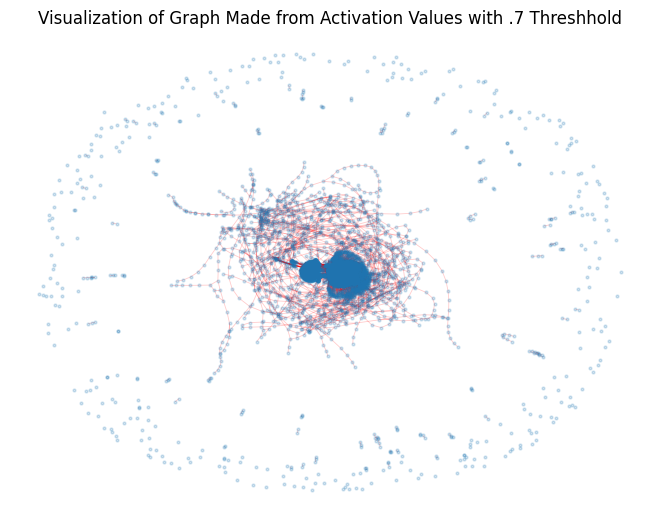

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

#plotting the networkx graph
pos = nx.spring_layout(G)  
nx.draw(
    G, pos,
    node_size=4,           
    edge_color="red",  
    width=.6,            
    with_labels=False,      
    alpha = .2
)
plt.title("Visualization of Graph Made from Activation Values with .7 Threshhold")
plt.show()


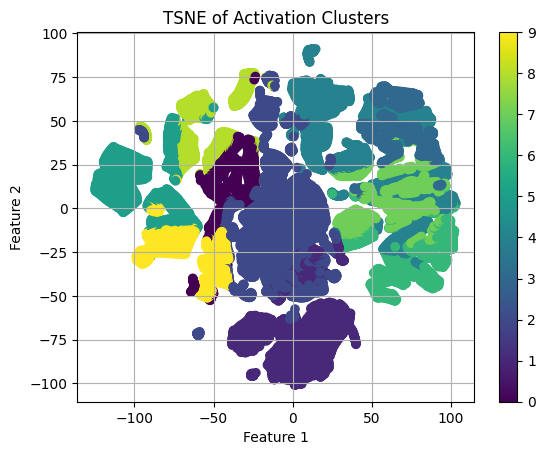

In [28]:
from sklearn.manifold import TSNE


#class labels
labels = np.load("activation_cluster_labels.npy")


#apply TSNE
tsne_activation = TSNE(n_components=2, random_state=42).fit_transform(activation_matrix)


#visualize TNSE
scatter = plt.scatter(tsne_activation[:, 0], tsne_activation[:, 1], c=labels)
plt.colorbar(scatter)
plt.title("TSNE of Activation Clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

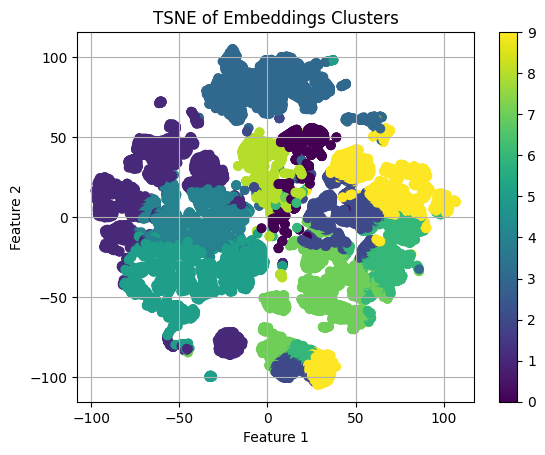

In [29]:
#class labels
labels = np.load("node2vec_cluster_labels.npy")


#apply TSNE
tsne_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings)


#visualize TNSE
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels)
plt.colorbar(scatter)
plt.title("TSNE of Embeddings Clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()
